In [1]:
from os import listdir
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Conv2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l2

from PIL import Image
import scipy.misc

Using TensorFlow backend.


In [2]:
cancer_filename = "../CancerFPKM.txt"
normal_filename = "../NormalFPKM.txt"

cancer_data = pd.read_table(cancer_filename, header=None)
cancer_data_t = cancer_data.T
cancer_data_tmp = cancer_data_t
cancer_data_tmp.columns = cancer_data_tmp.iloc[0]
cData = cancer_data_tmp.drop(0)

normal_data = pd.read_table(normal_filename, header=None)
normal_data_t = normal_data.T
normal_data_tmp = normal_data_t
normal_data_tmp.columns = normal_data_tmp.iloc[0]
nData = normal_data_tmp.drop(0)
nData.shape

(730, 60483)

In [3]:
cData.shape

(1034, 60483)

In [4]:
allData = pd.concat([cData, nData], ignore_index=True)
#d = np.array(allData.values, dtype='float')
dat = allData.values
dat = dat.astype('float32')
dat[np.isnan(dat)] = 0

In [5]:
# Add 12 zero columns
Y_cancer = np.ones(1034)
Y_normal = np.zeros(730)

dat_Y = np.append(Y_cancer, Y_normal)
dat = np.c_[ dat, np.zeros(shape=(dat.shape[0], 17))]

In [6]:
dat.shape

(1764, 60500)

In [7]:
from sklearn.cross_validation import train_test_split
x_train, x_test, y_train, y_test = train_test_split(dat, dat_Y, test_size=0.2, random_state=123, stratify=dat_Y)

/anaconda/envs/py35/lib/python3.5/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [8]:
x_train = x_train.reshape(x_train.shape[0], 250, 242, 1)
x_test = x_test.reshape(x_test.shape[0], 250, 242, 1)

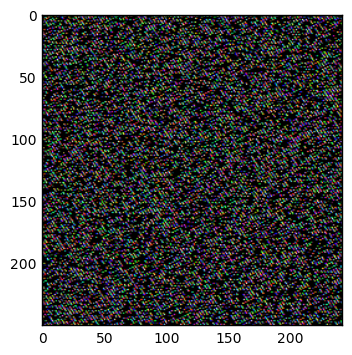

In [22]:
a = x_train[1]
a = Image.fromarray(a, 'RGB')
plt.imshow(a)

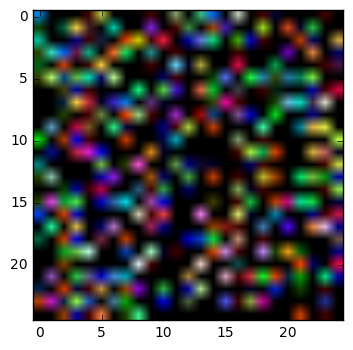

In [30]:
b = a.resize((25,25))
plt.imshow(b)

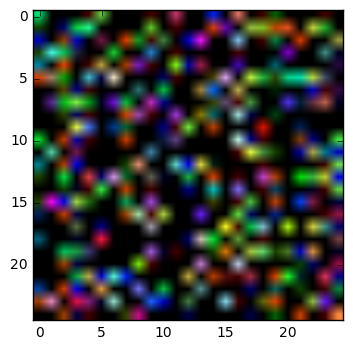

In [31]:
c = x_train[0]
c = Image.fromarray(c, 'RGB')
c = c.resize((25,25))
plt.imshow(c)

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, RepeatVector, Reshape
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam
from keras.layers.normalization import BatchNormalization
from keras.layers.advanced_activations import LeakyReLU
from keras.regularizers import l1, l2


In [31]:
### Model Settings ###
model = Sequential()

model.add( Conv2D(64, 5, kernel_regularizer=l2(.005), padding='same', input_shape=(250,242,1)) )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))
model.add(Dropout(0.5))
model.add( MaxPooling2D(pool_size=(2,2)))

model.add( Conv2D(64, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))
model.add(Dropout(0.25))


model.add( Conv2D(32, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))

model.add( Conv2D(32, 5, kernel_regularizer=l2(.005), padding='same') )
model.add(LeakyReLU(alpha=0.1))
model.add(BatchNormalization(momentum=.9, scale=False))

model.add(Flatten())
model.add(Dense(64, activation='relu', kernel_regularizer=l2(.005)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(.005)))
model.add(Dense(1, activation='softmax', kernel_regularizer=l2(.005)))


# Define optimizer
optimizer = Adam(lr=0.001)

model.compile(loss='binary_crossentropy',
              optimizer=optimizer,
              metrics=['accuracy'])



In [32]:
model.fit(x_train, y_train, batch_size=50, epochs=2)
result = model.evaluate(x_test, y_test)
print(result)

Epoch 1/2


ResourceExhaustedError: OOM when allocating tensor with shape[50,250,242,64]
	 [[Node: batch_normalization_33/moments/sufficient_statistics/Sub = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](leaky_re_lu_33/sub, batch_normalization_33/moments/StopGradient)]]
	 [[Node: batch_normalization_35/moments/sufficient_statistics/Gather/_573 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1423_batch_normalization_35/moments/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]

Caused by op 'batch_normalization_33/moments/sufficient_statistics/Sub', defined at:
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 184, in _run_module_as_main
    "__main__", mod_spec)
  File "/anaconda/envs/py35/lib/python3.5/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py", line 3, in <module>
    app.launch_new_instance()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/traitlets/config/application.py", line 658, in launch_instance
    app.start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelapp.py", line 474, in start
    ioloop.IOLoop.instance().start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/ioloop.py", line 177, in start
    super(ZMQIOLoop, self).start()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/ioloop.py", line 887, in start
    handler_func(fd_obj, events)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 440, in _handle_events
    self._handle_recv()
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 472, in _handle_recv
    self._run_callback(callback, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/zmq/eventloop/zmqstream.py", line 414, in _run_callback
    callback(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tornado/stack_context.py", line 275, in null_wrapper
    return fn(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 276, in dispatcher
    return self.dispatch_shell(stream, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 228, in dispatch_shell
    handler(stream, idents, msg)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/kernelbase.py", line 390, in execute_request
    user_expressions, allow_stdin)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/ipkernel.py", line 196, in do_execute
    res = shell.run_cell(code, store_history=store_history, silent=silent)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/zmqshell.py", line 501, in run_cell
    return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2723, in run_cell
    interactivity=interactivity, compiler=compiler, result=result)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2825, in run_ast_nodes
    if self.run_code(code, result):
  File "/anaconda/envs/py35/lib/python3.5/site-packages/IPython/core/interactiveshell.py", line 2885, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-e329ebc761f1>", line 6, in <module>
    model.add(BatchNormalization(momentum=.9, scale=False))
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/models.py", line 463, in add
    output_tensor = layer(self.outputs[0])
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/engine/topology.py", line 578, in __call__
    output = self.call(inputs, **kwargs)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/layers/normalization.py", line 140, in call
    epsilon=self.epsilon)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/keras/backend/tensorflow_backend.py", line 1482, in normalize_batch_in_training
    shift=None, name=None, keep_dims=False)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 617, in moments
    y, axes, shift=shift, keep_dims=keep_dims, name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/nn_impl.py", line 534, in sufficient_statistics
    m_ss = math_ops.subtract(x, shift)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/math_ops.py", line 282, in subtract
    return gen_math_ops._sub(x, y, name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/ops/gen_math_ops.py", line 2775, in _sub
    result = _op_def_lib.apply_op("Sub", x=x, y=y, name=name)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/op_def_library.py", line 763, in apply_op
    op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 2327, in create_op
    original_op=self._default_original_op, op_def=op_def)
  File "/anaconda/envs/py35/lib/python3.5/site-packages/tensorflow/python/framework/ops.py", line 1226, in __init__
    self._traceback = _extract_stack()

ResourceExhaustedError (see above for traceback): OOM when allocating tensor with shape[50,250,242,64]
	 [[Node: batch_normalization_33/moments/sufficient_statistics/Sub = Sub[T=DT_FLOAT, _device="/job:localhost/replica:0/task:0/gpu:0"](leaky_re_lu_33/sub, batch_normalization_33/moments/StopGradient)]]
	 [[Node: batch_normalization_35/moments/sufficient_statistics/Gather/_573 = _Recv[client_terminated=false, recv_device="/job:localhost/replica:0/task:0/cpu:0", send_device="/job:localhost/replica:0/task:0/gpu:0", send_device_incarnation=1, tensor_name="edge_1423_batch_normalization_35/moments/sufficient_statistics/Gather", tensor_type=DT_FLOAT, _device="/job:localhost/replica:0/task:0/cpu:0"]()]]


In [61]:
pred_results = model.predict_classes(x_test, batch_size=32, verbose=1)

1029/1029 [==============================] - 158s     

In [67]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, classes = None,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

TypeError: object of type 'NoneType' has no len()

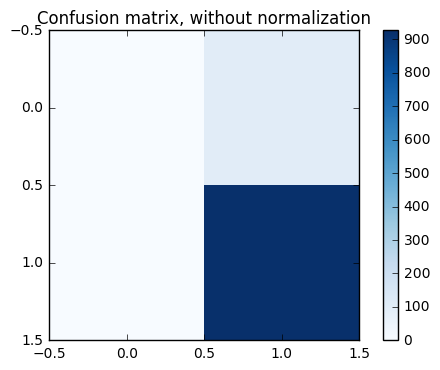

In [69]:
cm=confusion_matrix(y_test, pred_results)

plt.figure()
plot_confusion_matrix(cm, classes=None,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cm, classes=None, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [72]:
confusion_matrix = cm
FP = confusion_matrix.sum(axis=0) - np.diag(confusion_matrix)  
FN = confusion_matrix.sum(axis=1) - np.diag(confusion_matrix)
TP = np.diag(confusion_matrix)
TN = confusion_matrix.sum() - (FP + FN + TP)

# Sensitivity, hit rate, recall, or true positive rate
TPR = TP/(TP+FN)
# Specificity or true negative rate
TNR = TN/(TN+FP) 
# Precision or positive predictive value
PPV = TP/(TP+FP)
# Negative predictive value
NPV = TN/(TN+FN)
# Fall out or false positive rate
FPR = FP/(FP+TN)
# False negative rate
FNR = FN/(TP+FN)
# False discovery rate
FDR = FP/(TP+FP)

/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:12: RuntimeWarning: invalid value encountered in true_divide
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:14: RuntimeWarning: invalid value encountered in true_divide
/anaconda/envs/py35/lib/python3.5/site-packages/ipykernel/__main__.py:20: RuntimeWarning: invalid value encountered in true_divide


In [73]:
confusion_matrix.sum(axis=0)

array([   0, 1029])